# **AN2DL First Challenge**
> ## ***Ibuprofen*** team

## 🌐 **Google Drive setup**

In [1]:
from google.colab import drive

drive.mount("/gdrive", force_remount=True)
working_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis"
input_dir = working_dir

%cd $working_dir

print(f"Working at folder: {working_dir}")
print(f"Input at folder: {input_dir}")

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis
Working at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis
Input at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis


## 🌐 **Kaggle setup**

In [ ]:
working_dir = "/kaggle/working"
input_dir = "/kaggle/input"

---
## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cpu


---
## ⏳ **Data loading**

### Search for data in the working directory and load it

In [3]:
dataset_name = "an2dl2526c1"

dataset_dir = f"{input_dir}/{dataset_name}"

# Check if data directory exists
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset folder not found for '{dataset_name}' at expected input path: {input_dir}")
# Load data
else:
  print(f"Dataset folder found for '{dataset_name}': {dataset_dir}")

  try:
      df_features_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train.csv')
      df_labels_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train_labels.csv')
      df_test_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_test.csv')
  except FileNotFoundError as e:
        print(f"Error: CSV file {e.filename} not found at expected data path: {dataset_dir}")
  print(f"Dataset '{dataset_name}' loaded successfully")

Dataset folder found for 'an2dl2526c1': /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis/an2dl2526c1
Dataset 'an2dl2526c1' loaded successfully


## 🔎 **Data exploration and analysis**

### Inspect features at a glance

In [4]:
# Display the first few rows
print(f"Features shape: {df_features_raw.shape}")
print("Visual inspection of feature values:")
df_features_raw.head()

Features shape: (105760, 40)
Visual inspection of feature values:


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_21  \
0              1    two     two    two  1.094705  ...  3.499558e-06   
1              2    two     two    two  1.135183  ...  3.976952e-07   
2              2    two     two    two  1.080745  ...  1.533820e-07   
3              2    two     two    two  0.938017  ...  1.006865e-05   
4              2    two     two    two  1.090185  ...  4.437266e-06   

       joint_22  joint_23      joint_24  joint_25  joint_26  joint_27  \
0  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592  0.013508   
1  6.765107e-07  0.000006  4.643774e-08  0.000000  0.013352  0.000000   
2  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225  0.008110   
3  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832  0.007450   
4  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360  0.002532   

   joint_28  joint_29  joint_30  
0  0.026798  0.027815       0.5  
1  0.013377  0.013716       0.5  
2  0.024097  0.023105       0.5  
3  0.028613  0.024648       0.5  
4  0.033026  0.025328       0.5  

[5 rows x 40 columns]

In [5]:
# Utility definitions
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(31)] # joint_00 to joint_30


# Check missing values
num_features_any_null = df_features_raw.isnull().any(axis=1).sum()
print(f"\nFound {num_features_any_null} feature rows with null values")

# Check data types
feature_objects = df_features_raw.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound {len(feature_objects)} object columns in features to be properly encoded: {feature_objects}")
for col in feature_objects:
    print(f"    Column '{col}': {df_features_raw[col].unique()}")

# Check static features (body_parts_cols) consistency per sample_index
body_parts_consistency = df_features_raw.groupby('sample_index')[body_parts_cols].nunique()
body_parts_inconsistencies = (body_parts_consistency != 1).any(axis=1).sum()
print(f"\nFound {body_parts_inconsistencies} inconsistencies in 'n_legs', 'n_hands' or 'n_eyes' static values")

# Display DataFrame info
print(f"\nFeatures shape: {df_features_raw.shape}")
print(f"\nFeatures inspection:")
df_features_raw.info()


Found 0 feature rows with null values

Found 3 object columns in features to be properly encoded: ['n_legs', 'n_hands', 'n_eyes']
    Column 'n_legs': ['two' 'one+peg_leg']
    Column 'n_hands': ['two' 'one+hook_hand']
    Column 'n_eyes': ['two' 'one+eye_patch']

Found 0 inconsistencies in 'n_legs', 'n_hands' or 'n_eyes' static values

Features shape: (105760, 40)

Features inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9 

### Inspect labels at a glance

In [6]:
# Display the first few rows
print(f"Labels shape: {df_labels_raw.shape}")
print("Visual inspection of label values:")
df_labels_raw.head()

Labels shape: (661, 2)
Visual inspection of label values:


sample_index     label
0             0   no_pain
1             1   no_pain
2             2  low_pain
3             3   no_pain
4             4   no_pain

In [7]:
# Check missing values
num_labels_any_null = df_labels_raw.isnull().any(axis=1).sum()
print(f"\nFound {num_labels_any_null} feature rows with null values")

# Check data types
label_objects = df_labels_raw.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound object columns in labels to be properly encoded: {label_objects}")
for col in label_objects:
    print(f"   Column '{col}': {df_labels_raw[col].unique()}")

# Display DataFrame info
print(f"\nLabels shape: {df_labels_raw.shape}")
print(f"\nLabels inspection:")
df_labels_raw.info()


Found 0 feature rows with null values

Found object columns in labels to be properly encoded: ['label']
   Column 'label': ['no_pain' 'low_pain' 'high_pain']

Labels shape: (661, 2)

Labels inspection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  661 non-null    int64 
 1   label         661 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


### Drop missing values

In [8]:
# Remove rows with any missing values
df_features_raw.dropna(axis=0, how='any', inplace=True)
df_labels_raw.dropna(axis=0, how='any', inplace=True)
print("\nMissing values removed from features and labels")


Missing values removed from features and labels


### Merge features and labels

In [9]:
# Print the number of unique samples in features
num_unique_features_samples = df_features_raw['sample_index'].nunique()
print(f"\nFound {num_unique_features_samples} unique samples in features")

# Print the number of unique samples in labels
num_unique_labels_samples = df_labels_raw['sample_index'].nunique()
print(f"\nFound {num_unique_labels_samples} unique samples in features")

# Verify that in labels each sample appears one time only
labels_sample_counts = df_labels_raw['sample_index'].value_counts()
if (labels_sample_counts == 1).all():
    print("\nEach sample is involved in ONE experiment only")
else:
    print("\nSamples may be involved in MULTIPLE experiments")


# Merge (left join) features and labels by sample_index
df_features_x_labels = pd.merge(df_features_raw, df_labels_raw, on='sample_index', how='left')
print(f"\nFeatures-X-Labels shape: {df_features_x_labels.shape}")
print(f"    Features shape: {df_features_raw.shape}")
print(f"    Labels shape: {df_labels_raw.shape}")

print(f"\nFeatures-X-Labels inspection:")
df_features_x_labels.head()


Found 661 unique samples in features

Found 661 unique samples in features

Each sample is involved in ONE experiment only

Features-X-Labels shape: (105760, 41)
    Features shape: (105760, 40)
    Labels shape: (661, 2)

Features-X-Labels inspection:


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_22  joint_23  \
0              1    two     two    two  1.094705  ...  1.945042e-06  0.000004   
1              2    two     two    two  1.135183  ...  6.765107e-07  0.000006   
2              2    two     two    two  1.080745  ...  1.698525e-07  0.000001   
3              2    two     two    two  0.938017  ...  5.511079e-07  0.000002   
4              2    two     two    two  1.090185  ...  1.735459e-07  0.000002   

       joint_24  joint_25  joint_26  joint_27  joint_28  joint_29  joint_30  \
0  1.153299e-05  0.000004  0.017592  0.013508  0.026798  0.027815       0.5   
1  4.643774e-08  0.000000  0.013352  0.000000  0.013377  0.013716       0.5   
2  2.424536e-06  0.000003  0.016225  0.008110  0.024097  0.023105       0.5   
3  5.432416e-08  0.000000  0.011832  0.007450  0.028613  0.024648       0.5   
4  5.825366e-08  0.000007  0.005360  0.002532  0.033026  0.025328       0.5   

     label  
0  no_pain  
1  no_pain  
2  no_pain  
3  no_pain  
4  no_pain  

[5 rows x 41 columns]

### Check number of time steps per sample
  > Each `samples_index` has been tracked for the same number of `time` steps: this simplifies sequence management.


Total number of samples: 661

Distribution of time steps per sample:
160    661
Name: count, dtype: int64

Saved time steps distribution plot to: 'time_steps_distribution.png'.


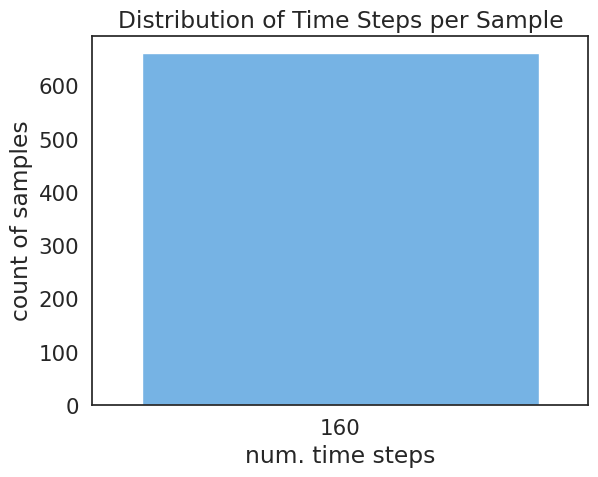

In [10]:
# Group by sample_index and take the number of rows per group (i.e., per sample)
time_steps_per_sample = df_features_x_labels.groupby('sample_index').size()

# Print total number of sample_index
print(f"\nTotal number of samples: {time_steps_per_sample.size}")

# Get the distribution of these sizes
time_step_distribution = time_steps_per_sample.value_counts()
print(f"\nDistribution of time steps per sample:\n{time_step_distribution}")

ax = sns.barplot(
    x=time_step_distribution.index,
    y=time_step_distribution.values,
    palette=["#64B5F6"]
)

plt.title('Distribution of Time Steps per Sample')
plt.xlabel('num. time steps')
plt.ylabel('count of samples')
plt.savefig("time_steps_distribution.png")
print("\nSaved time steps distribution plot to: 'time_steps_distribution.png'.")

### Check target labels distribution
  > It seems labels are not evenly-distributed: this has to be taken into account when splitting the training dataset into train set and validation set.


Distribution of labels:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Saved label distribution plot to: 'label_distribution.png'


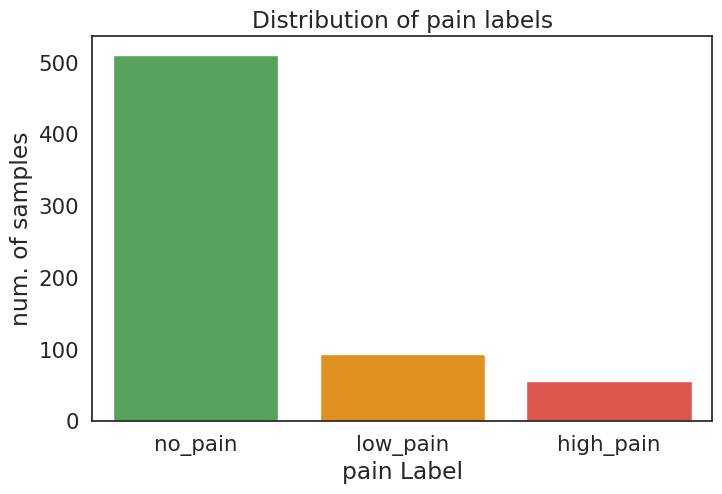

In [12]:
# Configure good-looking palette and order for pain :)
pain_plt_palette = {
    'no_pain': '#4CAF50',
    'low_pain': '#FF9800',
    'high_pain': '#F44336'
}
pain_plt_order = ['no_pain', 'low_pain', 'high_pain']

# Group labels and count sizes
print(f"\nDistribution of labels:")
label_counts = df_labels_raw['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    order=pain_plt_order,
    palette=pain_plt_palette
)
plt.title('Distribution of pain labels')
plt.xlabel('pain Label')
plt.ylabel('num. of samples')
plt.savefig("label_distribution.png")
print("\nSaved label distribution plot to: 'label_distribution.png'")

### Descriptive statistics: numeric features

Summary

In [13]:
# Define numeric features
numeric_cols = joint_cols

# Display summary for numeric features
print("\nDescriptive statistics summary (numeric features):")
numeric_stats = df_features_x_labels[numeric_cols].describe()
display(numeric_stats)


Descriptive statistics summary (numeric features):


joint_00       joint_01       joint_02       joint_03  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.943095       0.916955       0.779296       0.767921   
std         0.202051       0.197608       0.295605       0.300787   
min         0.000000       0.000000       0.001015       0.005403   
25%         0.828277       0.811445       0.568850       0.520020   
50%         1.005126       0.979468       0.909549       0.914834   
75%         1.081039       1.056611       0.995187       0.994324   
max         1.407968       1.334613       1.306046       1.254729   

            joint_04       joint_05       joint_06       joint_07  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.709186       0.711306       0.875185       0.837427   
std         0.418058       0.411783       0.240900       0.237904   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.184585       0.210551       0.839166       0.781375   
50%         0.930007       0.950628       0.937363       0.904914   
75%         1.036497       1.032400       1.013150       0.984410   
max         1.359204       1.387731       1.410532       1.361969   

            joint_08       joint_09  ...      joint_21      joint_22  \
count  105760.000000  105760.000000  ...  1.057600e+05  1.057600e+05   
mean        0.849700       0.909554  ...  3.972126e-05  4.176794e-05   
std         0.180489       0.180320  ...  4.974496e-03  5.472244e-03   
min         0.122095       0.004671  ...  0.000000e+00  1.510494e-07   
25%         0.717725       0.825898  ...  6.545878e-08  3.321650e-07   
50%         0.831221       0.940954  ...  8.302747e-07  1.095971e-06   
75%         0.991104       1.030941  ...  2.800090e-06  3.079465e-06   
max         1.357288       1.388105  ...  1.442198e+00  1.305001e+00   

           joint_23      joint_24      joint_25       joint_26       joint_27  \
count  1.057600e+05  1.057600e+05  1.057600e+05  105760.000000  105760.000000   
mean   3.561780e-05  3.138109e-05  1.024604e-04       0.041905       0.058244   
std    1.235450e-03  4.062914e-04  3.206128e-03       0.060293       0.079819   
min    0.000000e+00  1.063144e-08  0.000000e+00       0.000203       0.000000   
25%    3.275038e-07  2.841805e-07  7.161332e-07       0.009885       0.012652   
50%    1.024209e-06  8.746147e-07  3.126723e-06       0.021898       0.031739   
75%    3.021830e-06  2.507548e-06  9.946107e-06       0.048579       0.071051   
max    2.742411e-01  3.643074e-02  9.473540e-01       1.223617       1.187419   

            joint_28       joint_29  joint_30  
count  105760.000000  105760.000000  105760.0  
mean        0.049886       0.062273       0.5  
std         0.060773       0.072597       0.0  
min         0.000000       0.000000       0.5  
25%         0.016290       0.019638       0.5  
50%         0.031843       0.039041       0.5  
75%         0.058741       0.079518       0.5  
max         1.412037       1.370765       0.5  

[8 rows x 31 columns]

Check constant features
  > It seems the `joint_30` feature is constant: it could be dropped in data preprocessing.

In [14]:
# Check for constant numeric features
constant_numeric_cols = numeric_stats.columns[numeric_stats.loc["std"] == 0].tolist()

if len(constant_numeric_cols) > 0:
  print(f"\nFound {len(constant_numeric_cols)} constant numeric features with 0 variance: {constant_numeric_cols}")
  print("These features provide no information and should be dropped")
  for col in constant_numeric_cols:
    print(f"    Column '{col}': {df_features_x_labels[col].unique()}")
else:
  print("\nNo constant numeric feature found")


Found 1 constant numeric features with 0 variance: ['joint_30']
These features provide no information and should be dropped
    Column 'joint_30': [0.5]


Check order of magnitude of features' max and min
  > Joint features may differ a lot both in terms of scales of maximum and minimum, and range size: this reinforces the need to normalize each feature based on its maximum and minimum values.


Saved plot of log10 of joint max and min values to: 'joint_max_min_log10.png'


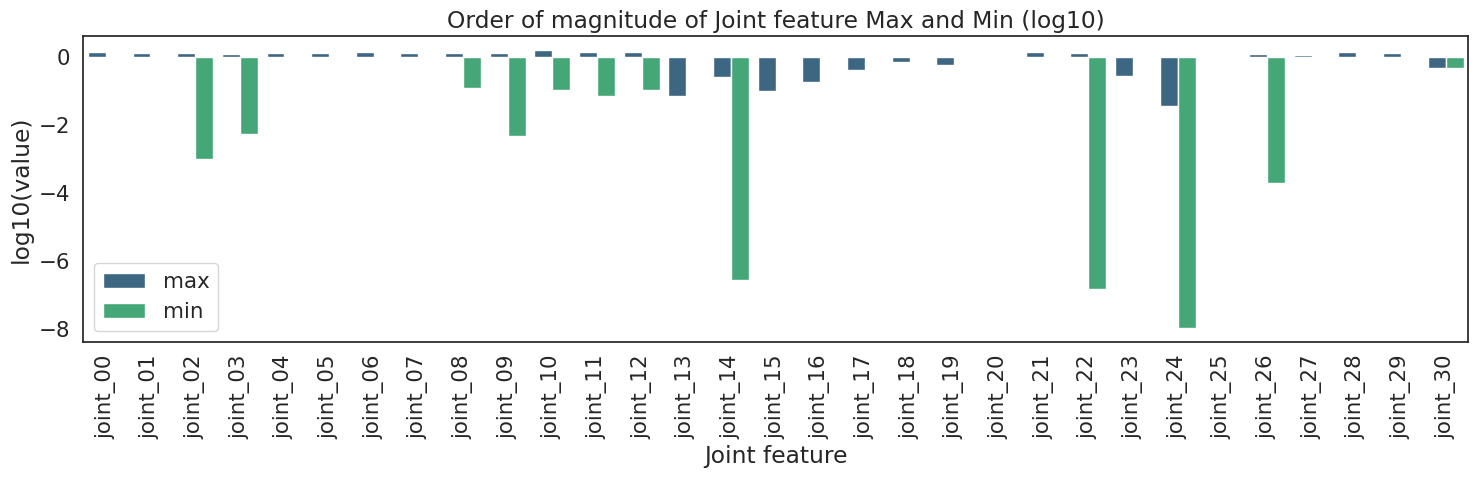

In [15]:
# Compute the base-10 logarithm of the absolute maximum and minimum values
numeric_cols_max_log10 = np.log10(np.abs(numeric_stats.loc["max"]))
numeric_cols_min_log10 = np.log10(np.abs(numeric_stats.loc["min"]))

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Feature': numeric_cols_max_log10.index.tolist() + numeric_cols_min_log10.index.tolist(),
    'Order of Magnitude (log10)': numeric_cols_max_log10.values.tolist() + numeric_cols_min_log10.values.tolist(),
    'Type': ['max'] * len(numeric_cols_max_log10) + ['min'] * len(numeric_cols_min_log10)
})

# Display
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Feature', y='Order of Magnitude (log10)', hue='Type', data=plot_data, palette="viridis")
plt.xticks(rotation=90)
plt.title('Order of magnitude of Joint feature Max and Min (log10)')
plt.xlabel('Joint feature')
plt.ylabel('log10(value)')
plt.tight_layout()
plt.savefig("joint_max_min_log10.png")
print("\nSaved plot of log10 of joint max and min values to: 'joint_max_min_log10.png'")

# Remove the legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title=None)

plt.show()

### Descriptive statistics: categorical features

Summary


Descriptive statistics summary (categorical features)


pain_survey_1  count  pain_survey_2  count  pain_survey_3  count  \
0              0  12352              0  11760              0  11529   
1              1  14031              1  12983              1  13573   
2              2  79377              2  81017              2  80658   

   pain_survey_4  count  
0              0  11361  
1              1  12905  
2              2  81494


Saved pain_survey_distributions.png plot to: 'pain_survey_distributions.png'


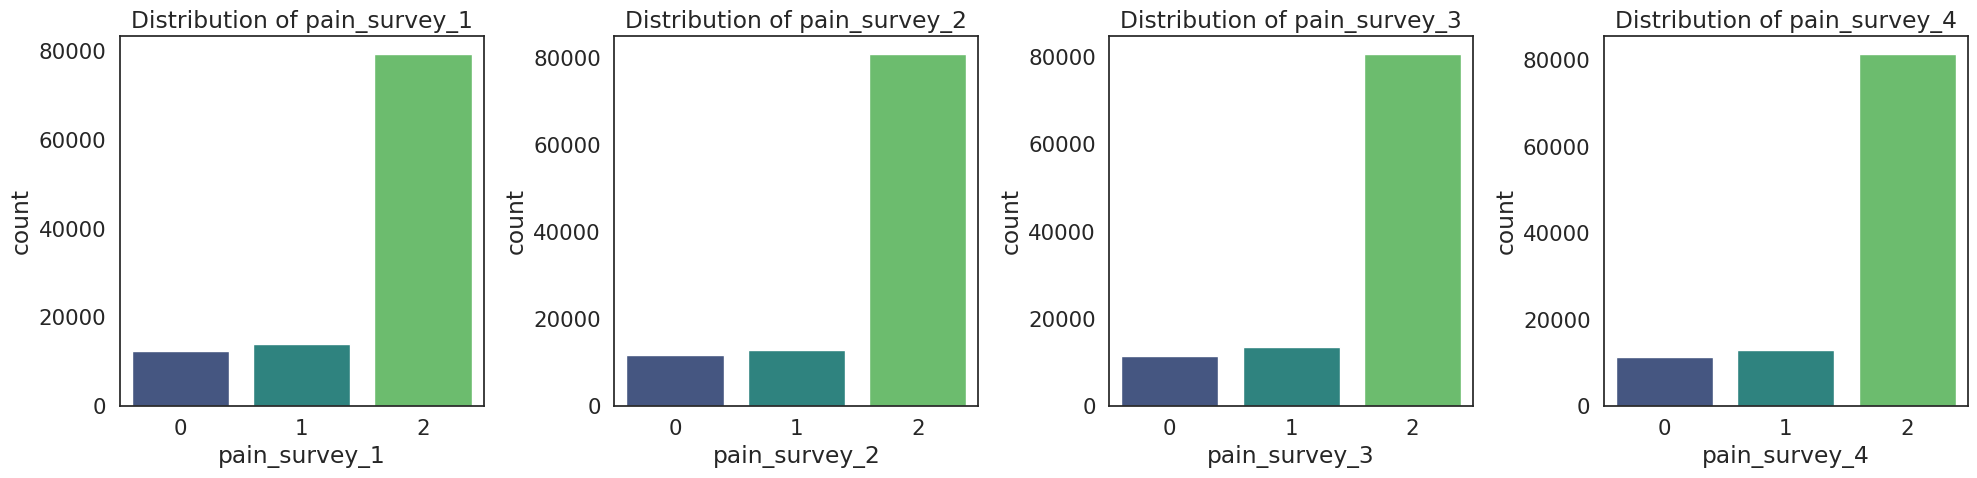

n_legs  count        n_hands  count         n_eyes  count
0  one+peg_leg      6  one+hook_hand      6  one+eye_patch      6
1          two    655            two    655            two    655


Saved body_parts_distributions.png plot to: 'body_parts_distributions.png'


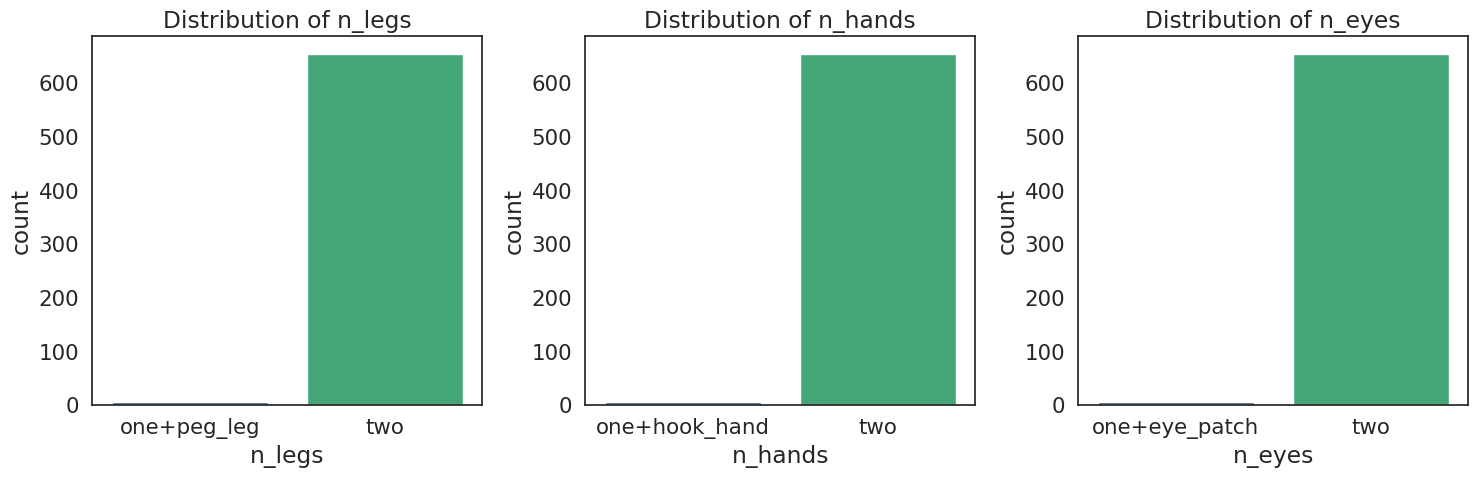

In [16]:
def plot_categorical_distributions(df, cols, palette, filename):
    """Plots count distributions for a list of categorical columns and prints frequencies."""
    n_cols = len(cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Ensure axes is an array even if there's only one column
    if n_cols == 1:
        axes = [axes]

    freq_dfs = []
    for i, col in enumerate(cols):
        # Prepare frequencies to be displayed
        freq_df = df[col].value_counts().sort_index().reset_index()
        freq_df.columns = [col, 'count']
        freq_dfs.append(freq_df)

        # Plot distributions
        sns.countplot(
            x=col,
            data=df,
            palette=palette,
            order=df[col].value_counts().sort_index().index,
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('count')

    # Display frequencies side by side
    display(pd.concat(freq_dfs, axis=1))

    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nSaved {filename} plot to: '{filename}'")
    plt.show()

# Display summary for categorical features
print("\nDescriptive statistics summary (categorical features)")
plot_categorical_distributions(df_features_x_labels, pain_survey_cols, "viridis", "pain_survey_distributions.png")
plot_categorical_distributions(df_features_x_labels.groupby('sample_index')[body_parts_cols].head(1), body_parts_cols, "viridis", "body_parts_distributions.png")

Check constant features

In [18]:
constant_categorical_cols = df_features_x_labels[pain_survey_cols + body_parts_cols].nunique()
constant_categorical_cols = constant_categorical_cols[constant_categorical_cols == 1].index.tolist()

if len(constant_categorical_cols) > 0:
  print(f"\nFound {len(constant_categorical_cols)} constant categorical features: {constant_categorical_cols}")
  print("These features provide no information and should be dropped")
  for col in constant_categorical_cols:
    print(f"    Column '{col}': {df_features_x_labels[col].unique()}")
else:
  print("\nNo constant categorical feature found")


No constant categorical feature found


Correlation between missing body parts
  > It seems if one is missing, all are missing: they could be preprocessed into one single feature.


Body parts features combinations count:


n_legs       n_hands        n_eyes       
two          two            two              104800
one+peg_leg  one+hook_hand  one+eye_patch       960
Name: count, dtype: int64


Saved body parts correlation matrix plot to: 'body_parts_correlation_matrix.png'


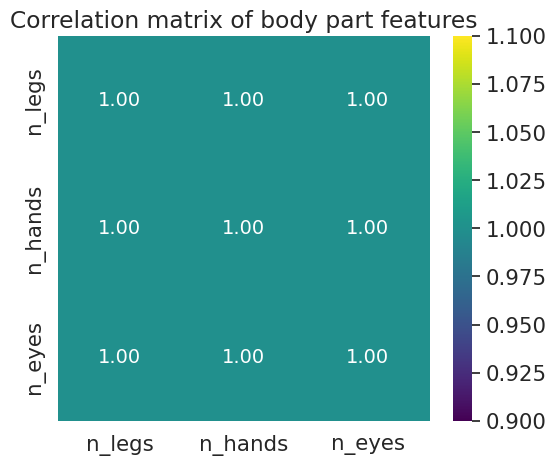

In [20]:
# Check the combinations of body parts features
print("\nBody parts features combinations count:")
display(df_features_x_labels[body_parts_cols].value_counts())

# Encode body part features into numbers
body_parts_encoded = df_features_x_labels.groupby('sample_index')[body_parts_cols].head(1).copy()
body_parts_encoded['n_legs'] = body_parts_encoded['n_legs'].apply(lambda x: 1 if x == 'one+peg_leg' else 0)
body_parts_encoded['n_hands'] = body_parts_encoded['n_hands'].apply(lambda x: 1 if x == 'one+hook_hand' else 0)
body_parts_encoded['n_eyes'] = body_parts_encoded['n_eyes'].apply(lambda x: 1 if x == 'one+eye_patch' else 0)

# Compute the correlation matrix
body_parts_correlation_matrix = body_parts_encoded.corr()

# Display the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(body_parts_correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation matrix of body part features')
plt.savefig("body_parts_correlation_matrix.png")
print("\nSaved body parts correlation matrix plot to: 'body_parts_correlation_matrix.png'")
plt.show()

Spearman' correlation of body parts (static) features against pain labels
  > Spearman's correlation assesses monotonic relationships (`no_pain` < `low_pain` <
  `high_pain`). </br>
  It seems body parts features have almost no correlation with pain: probably, they could be totally dropped.

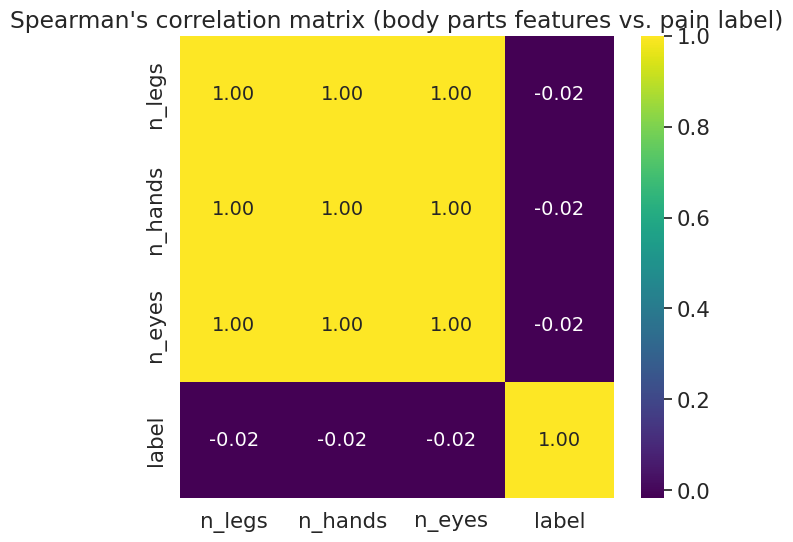


Body parts features Spearman's correlation against label:


n_legs    -0.016866
n_hands   -0.016866
n_eyes    -0.016866
Name: label, dtype: float64

In [21]:
# Create the monotonic encoding for the label
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Build the Spearman's correlation matrix
bp_x_labels_encoded = df_features_x_labels.groupby('sample_index')[[*body_parts_cols, 'label']].head(1).copy()
bp_x_labels_encoded['n_legs'] = bp_x_labels_encoded['n_legs'].apply(lambda x: 1 if x == 'one+peg_leg' else 0)
bp_x_labels_encoded['n_hands'] = bp_x_labels_encoded['n_hands'].apply(lambda x: 1 if x == 'one+hook_hand' else 0)
bp_x_labels_encoded['n_eyes'] = bp_x_labels_encoded['n_eyes'].apply(lambda x: 1 if x == 'one+eye_patch' else 0)
bp_x_labels_encoded['label'] = bp_x_labels_encoded['label'].map(label_mapping)
bp_x_labels_spearman_corr_matrix = bp_x_labels_encoded.corr(method='spearman')

# Display the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(bp_x_labels_spearman_corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Spearman's correlation matrix (body parts features vs. pain label)")
plt.show()

# Display the specific correlations
print("\nBody parts features Spearman's correlation against label:")
# Drop the label's correlation with itself
bp_spearman_corr_vs_labels = bp_x_labels_spearman_corr_matrix['label'].drop('label')
display(bp_spearman_corr_vs_labels)

### Autocorrelation for a random `sample_index`'s `joint_XX` by pain label
> At each `lag`, the plot quantifies the correlation between the time step `t` and the timestep `t-lag`. </br>
> Random samples for each pain label show very erratic trends. While individual time series may contain cyclical patterns, they do not appear to share a common length.
> * A *common* trend is samples with low/high pain having slowly-changing angle (difference with previous with small volatility and similar mean), no pain otherwise (fast-changing rolling mean, higher volatility).

Plotting autocorrelation for random sample_indices: {'no_pain': 427, 'low_pain': 96, 'high_pain': 43}


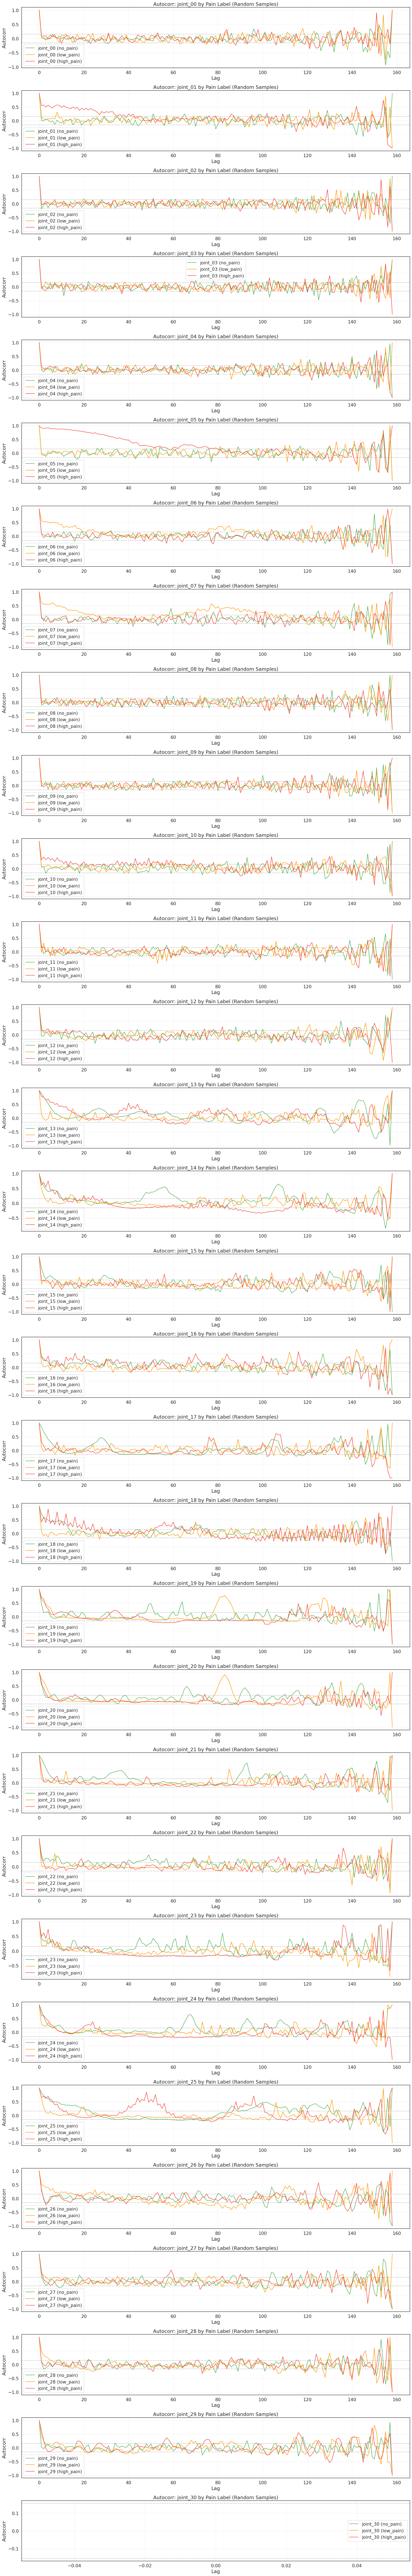

In [22]:
# Select a random sample_index for each pain label
random_sample_indices = {}
pain_labels = df_labels_raw['label'].unique()

for label in pain_labels:
    # Get sample indices with the current label
    sample_indices_with_label = df_labels_raw[df_labels_raw['label'] == label]['sample_index'].tolist()
    # Select a random sample index from this list
    random_sample_indices[label] = random.choice(sample_indices_with_label)

print(f"Plotting autocorrelation for random sample_indices: {random_sample_indices}")

# Calculate the number of subplots needed (one for each joint)
n_joints = len(joint_cols)
n_cols = 1  # Number of columns for subplots
n_rows = (n_joints + n_cols - 1) // n_cols # Calculate number of rows

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Calculate confidence interval for autocorrelation (approx. for large N)
# We'll use the minimum number of observations across all samples and joints for a conservative CI
min_N = df_features_raw.groupby('sample_index').size().min()
conf_interval = 1.96 / np.sqrt(min_N)


for i, col in enumerate(joint_cols):
    for label in pain_labels:
        sample_index = random_sample_indices[label]
        # Filter the dataframe for the selected sample_index
        df_random_sample = df_features_raw[df_features_raw['sample_index'] == sample_index]

        # Extract the joint feature data for the random sample
        joint_data = df_random_sample[col]

        # Calculate the autocorrelation
        autocorr_joint = [joint_data.autocorr(lag=j) for j in range(len(joint_data))]

        # Plot the autocorrelation on the current subplot
        axes[i].plot(autocorr_joint, label=f'{col} ({label})', color=pain_plt_palette[label])


    axes[i].set_title(f'Autocorr: {col} by Pain Label (Random Samples)')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorr')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

    # Add horizontal lines for confidence interval
    axes[i].axhline(conf_interval, color='gray', linestyle='--', alpha=0.5, label='95% CI (min N)')
    axes[i].axhline(-conf_interval, color='gray', linestyle='--', alpha=0.5)
    handles, labels_ = axes[i].get_legend_handles_labels()
    if '95% CI (min N)' not in labels_:
         axes[i].legend()


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()